# Big Data Project
<font size = 3>
Il presente progetto è stato realizzato da Luigi Gatto, Davide Lavalle e Cedric Ferdico. 
Il progetto di esame (a.a. 2020-2021) è una competizione Kaggle: un data set di frodi su carte di credito in cui sono presenti solo 492 frodi su 284808 transazioni. I dati contengono i campi "Time", "V1" ... "V28", "Amount" e "Class" che descriveremo in seguito.

È stato richiesto di effettuare tutti i passi di data cleaning/inputation e una analisi delle feature rilevanti ai fini della classificazione. 
La metrica richiesta è la Area Under the Precision-Recall Curve (AUPRC). Inoltre, è stata necessario trovare una modalità di visualizzazione dei dati classificati in 2D o 3D che consenta di mettere in relazione i punti appartenenti a ciascuna classe con le feature utilizzate per la classificazione ai fini di apprezzare l'effettiva separazione tra le classi.
</font>

## 0.Ecosistema
Per la realizzazione del progetto, è stato deciso di utilizzare i seguenti strumenti:
- HDFS: per lo storage del dataset (simulando un cluster unitario di datanode); 
- Spark: per il recupero (da HDFS) e l'elaborazione del dataset;
- Pandas: per la manipolazione e l'analisi dei dati;
- Scikitlearn: per l'apprendimento automatico e le metriche di valutazione dei modelli;
- Imblearn: conferisce dei tool utili alla classificazione di classi sbilanciate (utilizzata per effettuare il sovracampionamento);
- Numpy: per la gestione di matrici e array multidimensionali di grandi dimensioni e l'utilizzo di funzioni matematiche di alto livello per operare su queste strutture dati;
- Matplotlib/Seaborn: per la visualizzazione dei dati.

# 1.Descrizione del dataset

Il dataset analizzato nel progetto è un insieme di record di transazioni di carte di credito a cui è stato effettuato la PCA (per motivi di privacy). I dati sono raccolti in maniera continua: il tempo è segnato all'interno della colonna "Time" con un intero che indica l'ammontare di secondi passati tra la transazione i-esima e la prima (che, di conseguenza ha il valore di "Time" a 0). 
Il dataset analizzato presenta 284808 di record di transazioni al momento dell'analisi in questo progetto.

Il dataset è fornito in formato .csv.


## 1.1.DATASET
In questa tabella andremo a riassumere il contenuto del dataset dal punto di vista delle features, descrivendone il tipo ed il contenuto.

| **Feature** | **Tipo** | **Descrizione** |
|------------ |------------ |------------ |
| "Time" | _Int_ | Valore numerico che indica l'ammontare di secondi trascorsi tra la prima transazione e la i-esima, il valore per la prima transazione è 0. |
| "V1"..."V28" | _Float_ | Feature di dettaglio della transazione convertite con la PCA per questioni di privacy. |
| "Amount" | _Float_ | Valore numerico che indica l'ammontare della transazione. |
| "Class" | _Boolean_ | Valore 0/1 che indica se la transazione in oggetto sia frode (1) o lecita (0). |

# 2.Inizializzazione dell'ambiente
Qui andremo a descrivere brevemente la fase di inizializzazione degli strumenti utilizzati per il progetto.

## 2.1.Importazione del dataset in HDFS

Per prima, dopo aver effetuato l'installazione ed il setup di HDFS, è necessario avviare tutti i servizi Hadoop.
Per farlo è sufficiente eseguire un comando da CLI: 

``` >> start-all ```

A questo punto, una volta avviati tutti i servizi, sarà possibile caricare in HDFS il dataset.
Per effettuare l'upload, sarà sufficiente eseguire un altro comando CLI:

```>> hdfs fs -put "local/path/to/file.csv" "remote/path/" ```

Dove il primo parametro sta ad indicare la directory locale in cui è conservato il file .csv mentre il secondo indicherà la directory del file system distribuito in cui il dataset sarà caricato.

## 2.2.Spark
L'inizializzazione dell'ambiente Spark consiste nell'importazione dei relativi moduli e nell'inizializzazione di una nuova SparkSession.
Il motivo per cui è stato preso in considerazione l'utilizzo di Apache Spark è stato il suo ottimo rendimento in ambiti applicativi come questo. Infatti, questo strumento, è caratterizzato da un'alta velocità di elaborazione e di analisi avanzata; inoltre, dispone di un supporto di integrazione multipla con le operazioni a basso costo di Hadoop per la gestione dell’hardware e l’immagazzinamento dei dati.

In [1]:
import findspark

location = findspark.find()
findspark.init(location)

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder \
    .appName("Progetto BigData Gatto - Lavalle - Ferdico A.A. 2020/2021") \
    .getOrCreate()


21/11/01 11:43:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


# 3.Lettura del dataset da HDFS con Spark

Il codice seguente permette la lettura del file da HDFS e quindi l'importazione del dataset in formato .csv all'interno del dataframe secondo lo schema appena creato.
Il dataset è conservato in una simulazione di filesystem distribuito in locale. 
(Questa scelta è stata effettuata per permetterci di cimentarci nell'implementazione di un fs distribuito con lo strumento Hadoop)

In [2]:
dataSet = spark.read \
    .csv('hdfs://localhost:9099/creditCardProject/creditcard.csv', header = 'True', inferSchema='True')

# 4.Dataset preprocessing
La fase di preprocessing è necessaria per preparare il dataset appena caricato prima dell'analisi vera e propria. I dati presenti possono infatti presentare errori, dati mancanti o valori non previsti. L'obiettivo del preprocessing è quindi quello di pulire tali informazioni rimuovendo o "curando" i dati che presentano rumore o qualsiasi altro tipo di inconsistenze.

## 4.1 Osservazione sul dataset


Convertiamo il DataFrame Spark in un DataFrame Pandas che offre una libreria per facilitarne la gestione e l'elaborazione:

In [3]:
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt

df = dataSet.toPandas()

21/11/01 11:44:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Per prima cosa diamo uno sguardo a come le transazioni si evolvono nel tempo. <br>
<br>
Per farlo realizziamo un grafico che tenga conto dell'evoluzione del valore di "Amount" seguendo il trascorrere del tempo, marcando con il colore Rosso le frodi e con il colore Blu quelle lecite. <br>

Grafico: X--> Time; Y--> Amount ----- [Rosso frode - Blu non frode]

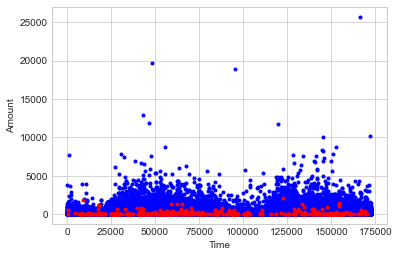

In [6]:
#Grafico non frode
xlim = df['Time'].max() * 1.2
ylim = df['Amount'].max() * 1.2

X = np.where(df['Class']==0, df['Time'], None)
Y = np.where(df['Class']==0, df['Amount'], None)

plt.style.use('seaborn-whitegrid')
plt.xlabel("Time")
plt.ylabel("Amount")
plt.scatter(X, Y, marker = ".", color = "blue")

X = np.where(df['Class']==1, df['Time'], None)
Y = np.where(df['Class']==1, df['Amount'], None)
plt.scatter(X, Y, marker = ".", color = "red")

Da questo grafico è possibile notare come alle transazioni per cui il valore di "Class" è uguale ad 1 (le frodi) corrispondano valori di "Amount" relativamente bassi (<2500). <br>
Inoltre è possibile percepire, anche se non del tutto chiaramente, il fatto che il dataset sia sbilanciato nei confronti delle transazioni lecite. 

Per verificare lo sbilanciamento del dataset abbiamo fatto stampare il numero delle transazioni lecite rispetto alle frodi:

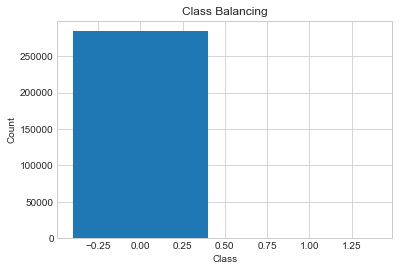

Numero transazioni lecite: 284315
Numero di frodi: 492


In [7]:
classi = []
classi.append(len(df.loc[df.Class == 0]))
classi.append(len(df.loc[df.Class == 1]))

plt.title("Class Balancing")
plt.xlabel("Class")
plt.ylabel("Count")
plt.bar([0, 1], classi)
plt.show()
print("Numero transazioni lecite: " + str(classi[0]))
print("Numero di frodi: " + str(classi[1]))

Da questa esecuzione risulta lampante lo sbilanciamento del dataset, agiremo quindi di conseguenza negli step succesivi.

## 4.2 Data cleaning



Banalmente, la prima operazione può essere quella di individuare le informazioni che presentano caratteristiche con valori mancanti. Il trattamento di valori mancanti può avvenire fondamentalmente in due modi: cancellazione o imputazione. La scelta corretta dipende dall'obiettivo dell'analisi e dalla possibile conoscenza a priori del problema, oltre ovviamente che dalle quantità di tali valori nulli.

In [8]:
dataSet.select([count(when(col(c).isNull(), c)).alias(c) for c in dataSet.columns]).show()

+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|Time| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|   0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



Dall'esecuzione precedente è possibile notare come tutte le features presenti nel dataset non presentino dati mancanti.
Procediamo adesso con il controllo di campioni duplicati all'interno del dataset. Per farlo utilizziamo il metodo "drop_duplicates" di pandas.

In [4]:
lunghezzaIniziale = len(df)
df.drop_duplicates(subset=df.columns.values[:-1], keep='first',inplace=True)
lunghezzaFinale = len(df)
print(f"Duplicati rimossi: {lunghezzaIniziale - lunghezzaFinale}")

Duplicati rimossi: 1081


Con l'esecuzione del codice precedente sono stati eliminati i dupliati.<br>
Dato che i valori di 28 features sulle 31 totali sono il risultato di una Principal Component Analysis effettuata sul dataset originario, quindi, diventa difficile effettuare operazioni di imputazione e/o rilevamento di inconsistenze sui dati.

## 4.3 Eliminazione delle features meno rilevanti

L'eliminazione delle feature meno rilevanti è necessaria per diversi motivi, tra i quali la riduzione di dimensionalità del problema (che alleggerirà il carico di lavoro successivo) e l'eliminazione di potenziali informazioni fuorvianti che sarebbero d'ostacolo all'addestramento del modello predittivo.

### 4.3.1 Matrice di correlazione
Procediamo adesso con il calcolo e la visualizzazione della matrice di correlazione. Abbiamo deciso di eliminare le feature con un valore di correlazione minore a 0.05 rispetto alla feature "Class".

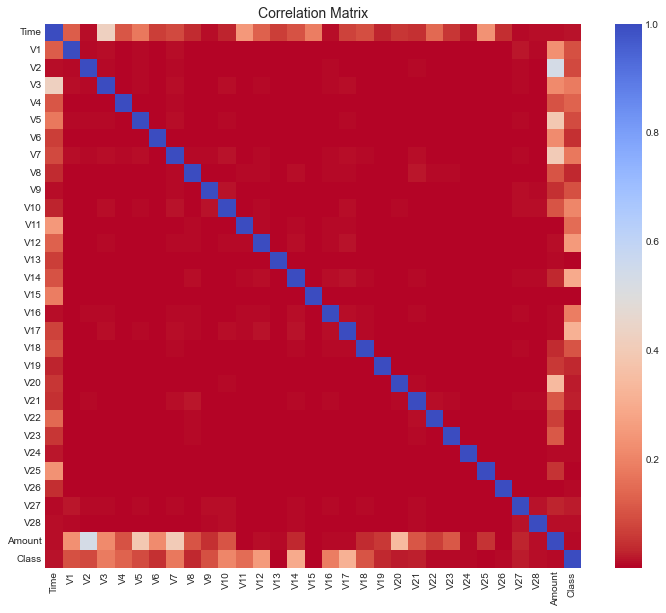

Valori minori della soglia per le feature: Time V6 V8 V13 V15 V19 V20 V21 V22 V23 V24 V25 V26 V27 V28 Amount 

In [10]:
import seaborn as sns
soglia = 0.05

plt.figure(figsize=(12, 10))
corr = df.corr()
corr = pd.DataFrame.abs(corr)
fig = sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20})
fig.set_title('Correlation Matrix', fontsize=14)
plt.show()

count = 0
print("Valori minori della soglia per le feature: ", end="")
for i in corr["Class"]:
    if i < soglia:
        print(corr["Class"].index[count], end=" ")
    count += 1

Dopo aver trovato le features che secondo la matrice di correlazione presentano una valore al di sotto della soglia, ne verifichiamo la coerenza con il fisher score.

## Fisher Score

@TODO: INSERIRE FORMULA FISHER SCORE

In [11]:
def fisher(m1,s1,p1,m2,s2,p2,m3):
  m1 = float(m1)
  s1 = float(s1)
  m2 = float(m2)
  s2 = float(s2)
  m3 = float(m3)

  num = p1 * ((m1 - m3)**2) + p2*((m2 - m3)**2)
  den = p1 * (s1**2) + p2 * (s2**2)

  return (100 * num/den)

frodi = dataSet.filter(dataSet.Class.contains(1))
legittime = dataSet.filter(dataSet.Class.contains(0))

# Describe Method Output:
# 0: count
# 1: mean
# 2: stddev
# 3: min
# 4: max

statFrodi       = frodi.describe().toPandas()
statLegittime   = legittime.describe().toPandas()
statGlobali     = dataSet.describe().toPandas()

suppFrodi       = float(statFrodi.loc[0,"Time"]) / float(statGlobali.loc[0,"Time"])
suppLegittime   = float(statLegittime.loc[0,"Time"]) / float(statGlobali.loc[0,"Time"])

print("Feature con score minori della soglia: ", end="")

for col in dataSet.columns[0:-1]:
    mediaFrodi      = float(statFrodi.loc[1,col])
    dsFrodi         = float(statFrodi.loc[2,col])
    mediaLegittime  = float(statLegittime.loc[1,col])
    dsLegittime     = float(statLegittime.loc[2,col])
    mediaGlobale    = float(statGlobali.loc[1,col])
    fisherValue = fisher(mediaFrodi, 
                          dsFrodi, 
                          suppFrodi, 
                          mediaLegittime,
                          dsLegittime,
                          suppLegittime,
                          mediaGlobale)
    
    if fisherValue < 0.5:                      
      print(col + " -", end=" ")

Feature con score minori della soglia: Time - V6 - V8 - V13 - V15 - V19 - V20 - V21 - V22 - V23 - V24 - V25 - V26 - V27 - V28 - Amount - 

Secondo la matrice di correlazione e secondo il fisher score, le features da eliminare combaciano. Di conseguenza il prossimo blocco di codice eliminerà proprio quelle features.

In [5]:
dfFinal = df.drop(["Time", "V6", "V8", "V13", "V15", "V19", "V20", "V21", "V22", "V23", "V24", "V25", "V26", "V27", "V28", "Amount"], axis=1)

# Min max Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
for col in dfFinal.columns[0:-1]:
    scaledCol = scaler.fit_transform(np.array(dfFinal[col]).reshape(-1, 1))
    dfFinal[col] = scaledCol

## X.X Suddiv

In [7]:
dfFinalClassFalse = dfFinal.loc[dfFinal.Class == 0]
dfFinalClassFalse = dfFinalClassFalse.drop(["Class"], axis = 1)

dfFinalClassTrue = dfFinal.loc[dfFinal.Class == 1]
dfFinalClassTrue = dfFinalClassTrue.drop(["Class"], axis = 1)

from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

pwsClassTrue = pairwise_distances(X = dfFinalClassTrue, metric="manhattan")
pwsClassFalse = pairwise_distances(X = dfFinalClassFalse.head(1000), metric="manhattan")

#MDS a due componenti con distanza Manhattan
embedding = MDS(n_components=2, dissimilarity="precomputed", random_state = 104)
xTrue_transformed = embedding.fit_transform(pwsClassTrue)
xFalse_transformed = embedding.fit_transform(pwsClassFalse)

plt.style.use('seaborn-whitegrid')
plt.scatter(xTrue_transformed[:, 0], xTrue_transformed[:, 1], marker = ".", color = 'green')
#plt.scatter(xFalse_transformed[:, 0], xFalse_transformed[:, 1], marker = ".", color = 'red')
plt.show()

#MDS a due componenti con distanza Euclidea
embedding = MDS(n_components=2, random_state = 104)
xTrue_transformed = embedding.fit_transform(dfFinalClassTrue)
xFalse_transformed = embedding.fit_transform(dfFinalClassFalse.head(1000))

plt.style.use('seaborn-whitegrid')
plt.scatter(xTrue_transformed[:, 0], xTrue_transformed[:, 1], marker = ".", color = 'green')
#plt.scatter(xFalse_transformed[:, 0], xFalse_transformed[:, 1], marker = ".", color = 'red')
plt.show()

KeyboardInterrupt: 

## X.X Salvataggio del cleaned dataset.csv
E' sicuramente conveniente salvare direttamente nel Drive personale il dataset così ottenuto per non ripetere i passaggi di data cleaning appena descritti ad ogni nuovo accesso a Colab. Per memorizzare il cleaned dataset, è possibile semplicemente utilizzare il metodo .write() fornito da Spark.
@Todo Dobbiamo farlo?

## X.X Importazione del cleaned dataset
cleaned_accidents_dataset.csv
Andiamo quindi ad importare il nuovo dataset cleaned_accidents_dataset.csv . Per farlo è necessario costruire nuovamente lo schema del dataframe che ospiterà il dataset e infine utilizzare il metodo read di Spark.

### 6.4 Scelta delle features @ToDo noi non possiamo farla, che ci mettiamo?

Più paragrafi sono stati dedicati alla pulizia del dataset, alla scelta delle features e quindi alla rimozione delle caratteristiche con dati mancanti o palesemente non necessari all'analisi. Per l'analisi predittiva ciò non basta,infatti alcune delle features possono essere in qualche modo implicitamente correlate al campo Severity , e per tale motivo utili alla sua predizione. Un possibile modo per individuare le features correlate è quello di utilizzare l'approccio statistico.
Calcolare le correlazioni tra la caratteristica Severity ed il resto è possibile calcolando la relativa matrice di correlazione. E' chiaro quindi che vanno escluse tutte le caratteristiche aventi una correlazione col campo preso in esame al di sotto di una certa soglia.
Per poter carcolare la matrice di correlazione, è possibile utilizzare un metodo fornito da Pandas. E' quindi necessario importare il dataset indicizzato all'interno di un suo dataframe:

Dalla matrice di correlazione appena ottenuta, va presa in considerazione soltanto la prima colonna ovvero quella relativa alle correlazioni tra la caratteristica Severity e ognuna delle altre caratteristiche.
Tanto è maggiore in valore assoluto la correlazione tra due variabili aleatorie, tanto più la conoscenza del valore di una è utile a prevedere il valore dell'altra. Per tale motivo è necessario calcolare i valori assoluti delle correlazioni tra
Severity e le altre caratteristiche, ed infine ordinarli in ordine decrescente:

Valutazione dell'errore del modello ottenuto al passo precedente

# ADDESTRAMENTO

6.9 Training
Per l'addestramento è necessario importare i modelli da addestrare dalle librerie di Spark per la classificazione. Come modelli verranno utilizzati Decision Tree ed il classificatore di tipo probabilistico Naive Bayes per poter confrontare infine i risultati ottenuti.
Per poter inizializzare i modelli è necessario prima inserire come parametri la caratteristica che il modello deve predire Severity , e la colonna delle features .


Creiamo test set e train set dal dataset e visualizziamo le loro dimensioni

Divisione del dataset in training set e validation set

In [8]:
from sklearn.model_selection import train_test_split

features = dfFinal[dfFinal.columns[:len(dfFinal.columns)-1]].to_numpy()
targets = dfFinal.Class.to_numpy()

X_train, X_test, Y_train, Y_test = train_test_split(features, targets, test_size=0.2, stratify=targets)
#X ingressi
print("Train Feature size : ", len(X_train))
print("Train Label size   :", len(Y_train))
print("Test Feature size  :", len(X_test))
print("Test Label size    :", len(Y_test))

Train Feature size :  226980
Train Label size   : 226980
Test Feature size  : 56746
Test Label size    : 56746


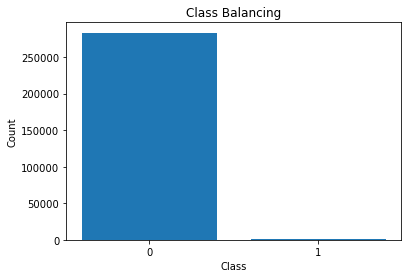

In [9]:
target_un,count = np.unique(targets,return_counts=True)
plt.title("Class Balancing")
plt.xlabel("Class")
plt.ylabel("Count")
plt.bar([str(i) for i in target_un],count)
plt.show()

6.8 Bilanciamento del dataset
Prima di continuare è necessario anche analizzare il bilanciamento delle classi appartenenti alla caratteristica Severity :

Il risulta mostra un bilanciamento non proprio uniforme. In particolare è possibile notare come la classe 1 e 4 sono quelle meno frequenti rispetto alle altre presenti. E' possibile bilanciare la distribuzione di tali classi attraverso l'oversampling. L'oversampling consiste nella duplicazione dei record delle le classi meno frequenti. Di conseguenza, va utilizzato il metodo .sample fornito sempre da Spark. Il metodo appena citato permette di specificare una frazione di record da estrarre dal dataframe da cui estrarre i campioni, con o senza sostituzione. L'oversampling sarà effettuato esclusivamente del training set per non influenzare i risultati della predizione da parte del modello.
Visuliazziamo la distribuzione delle classi per la stessa caratteristica ma soltanto per il Training Set:

Proviamo quindi a distribuire in maniera più uniforme tali classi tramite oversampling. E' evidente che l'oversampling debba essere seguito sui record aventi classi 1 , 3 e 4 di Severity .
Bisogna innanzitutto separare i record appartenenti alle stesse classe di Severity:

Come descritto prima, è necessario l'oversampling sui record appartenenti alle classi 1 , 3 e 4 . Il fattore di oversampling è gestibile tramite il parametro fraction di sample .

Controlliamo quindi se la distribuzione delle classi all'interno del dataset si è uniformata:

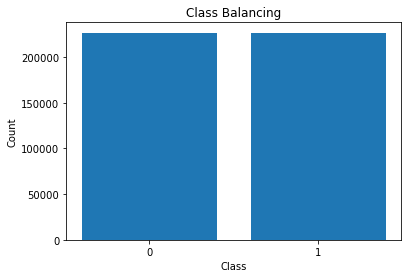

In [10]:
from imblearn.over_sampling import SMOTE

#SOVRACAMPIONAMENTO SOLO DEL TRAINING SET IN MODO DA SBAGLIARE SOLO 1 VOLTA E NON N VOLTE NEL TEST SET
X_train, Y_train = SMOTE().fit_resample(X_train,Y_train)
Y_train = Y_train.reshape(-1,1)

target_balanced,count = np.unique(Y_train,return_counts=True)
plt.title("Class Balancing")
plt.xlabel("Class")
plt.ylabel("Count")
plt.bar([str(i) for i in target_balanced],count)
plt.show()

In [18]:
from sklearn.ensemble import RandomForestClassifier

#model = RandomForestClassifier(n_estimators=108, max_features="sqrt", criterion="entropy")
#model.fit(X_train, Y_train)

In [19]:
#from sklearn.model_selection import StratifiedKFold, GridSearchCV
#gridParams = {
#    'criterion': ["gini", "entropy"],
#    'max_features': ["sqrt", "log2"],
#    'max_depth': [5, 10, 15, 20, 25]
#}
#rfCLF = RandomForestClassifier(n_estimators = 150, n_jobs = -1)
#stratified = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1234)
#gridSearch = GridSearchCV(estimator = rfCLF,
#                          param_grid = gridParams,
#                          scoring = 'f1',
#                          cv = stratified,
#                          n_jobs = -1)
#gridSearch.fit(X_train, Y_train)

/Applications/anaconda3/envs/mongoDB/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Applications/anaconda3/envs/mongoDB/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Applications/anaconda3/envs/mongoDB/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:681: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Applications/anaconda3/envs/mongoDB/lib/python3.8/site-packages

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=RandomForestClassifier(n_estimators=150, n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15, 20, 25],
                         'max_features': ['sqrt', 'log2']},
             scoring='f1')

# 6 Prediction e valutazione dei modelli
Ora che i modelli sono stati addestrati, è finalmente possibile iniziare la predizione di Severity utilizzando il test set. Di conseguenza, viene utilizzato il metodo .transform() che restituisce direttamente il dataframe contenente la predizione dei modelli utilizzati e la relativa label corretta.
Per la valutazione dei modelli appena addestrati, vengono utilizzate le metriche fornite dalle librerie Scikit-learn , ovvero librerie di machine learning open-source scritte in Python.
Tutte le metriche fornite dalle librerie da Scikit-learn utilizzano come parametri di input y_true e y_pred . Queste rappresentano rispettivamente le label verità e le label predette dal classificatore. Tali parametri possono essere prelevati direttamente dai dataframe ottenuti nel passaggio precedente:

## 6.1 Matrice di confusione
L'accuratezza è semplicemente la percentuale delle istanze classificate correttamente. Calcoliamo quindi l'accuracy dei modelli addestrati:

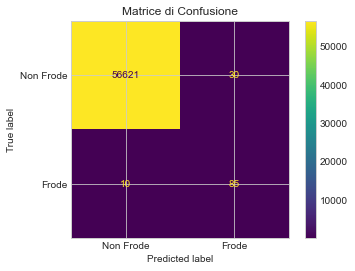

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

trainPredetto = gridSearch.predict(X_train)
testPredetto = gridSearch.predict(X_test)

cm = confusion_matrix(Y_test, testPredetto, labels=[0, 1])

cmatrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Frode","Frode"])
cmatrix.plot()
plt.title("Matrice di Confusione")
plt.show()


## 6.2 Percentuali successo su Train-set e Test-set

In [21]:
from sklearn.metrics import accuracy_score

veriNegativi = cm[0][0]
veriPositivi = cm[1][1]
falsiPositivi = cm[0][1]
falsiNegativi = cm[1][0]   

nonFrodiTotali = veriNegativi + falsiPositivi
frodiTotali = veriPositivi + falsiNegativi

percentualeDiSuccessoNonFrodi = veriNegativi / nonFrodiTotali
percentualeDiSuccessoFrodi = veriPositivi / frodiTotali

precision = veriPositivi/(veriPositivi + falsiPositivi)
recall = veriPositivi/(veriPositivi + falsiNegativi)
print("Train score     : {:.2f} %".format(accuracy_score(trainPredetto, Y_train) * 100))
print("Test Accuracy     : {:.2f} %".format(accuracy_score(testPredetto, Y_test) * 100))
print("Test Precision     : {:.2f} %".format(100 * precision))
print("Test Recall     : {:.2f} %".format(100 * recall))
print("Test F1     : {:.2f} %".format(100 * 2 * precision * recall /(precision + recall)))

print("Accuratezza riconoscimento frodi : {:.2f} %".format(percentualeDiSuccessoFrodi*100))
print("Accuratezza riconoscimento non frodi : {:.2f} %".format(percentualeDiSuccessoNonFrodi*100))


Train score     : 100.00 %
Test Accuracy     : 99.93 %
Test Precision     : 73.91 %
Test Recall     : 89.47 %
Test F1     : 80.95 %
Accuratezza riconoscimento frodi : 89.47 %
Accuratezza riconoscimento non frodi : 99.95 %


## 6.X AUPRC

0.0016741268107003137	0.661503454996092


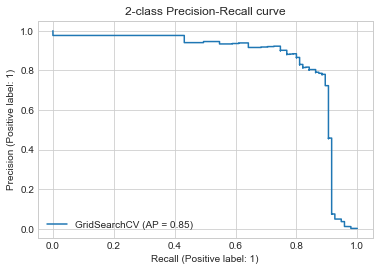

In [22]:
from sklearn.metrics import average_precision_score

baseline = frodiTotali/(frodiTotali + nonFrodiTotali)
auprc = average_precision_score(Y_test, testPredetto)

print(baseline, auprc, sep="\t")

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(gridSearch, X_test, Y_test)

_ = display.ax_.set_title("2-class Precision-Recall curve")



### 6.10.2 Balanced Accuracy
Nei casi in cui il dataset non sia bilanciato nel migliore dei modi, come nel nostro caso, ha senso anche la valutazione della balanced accuracy che calcola la media aritmetica delle accuratezze specifiche delle classi:

### 6.10.3 F1 Micro
Valutazione della F1 micro dei modelli addestrati:

### 6.10.4 F1 Macro
Valutazione della F1 macro dei modelli addestrati:

$O = \sum \limits _{i, j : i < j} (||X_{i} - X_{j}|| - δ_{ij})^2 $

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier
x = ["relu"] # activation
y = ["adam"] # solver
z = [(100, 10), (100, 20), (100, 30)] # hidden_layer_sizes

best_model = None
bestF1 = 0
for i in x:
    for j in y:
        for k in z:
            rfCLF = MLPClassifier(activation = i, solver = j, hidden_layer_sizes=k, max_iter=10000)
            rfCLF.fit(X_train, Y_train)
            testPredetto = rfCLF.predict(X_test)
            
            cm = confusion_matrix(Y_test, testPredetto, labels=[0, 1])
            veriNegativi = cm[0][0]
            veriPositivi = cm[1][1]
            falsiPositivi = cm[0][1]
            falsiNegativi = cm[1][0]   

            precision = veriPositivi/(veriPositivi + falsiPositivi)
            recall = veriPositivi/(veriPositivi + falsiNegativi)
            f1 = 100 * 2 * precision * recall /(precision + recall)
            if f1 > bestF1:
                bestF1 = f1
                best_model = rfCLF

/Applications/anaconda3/envs/mongoDB/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda3/envs/mongoDB/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda3/envs/mongoDB/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


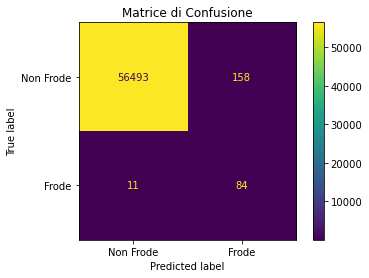

Train score     : 93.52 %
Test Accuracy     : 99.70 %
Test Precision     : 34.71 %
Test Recall     : 88.42 %
Test F1     : 49.85 %
Accuratezza riconoscimento frodi : 88.42 %
Accuratezza riconoscimento non frodi : 99.72 %
0.0016741268107003137	0.30710989671901195


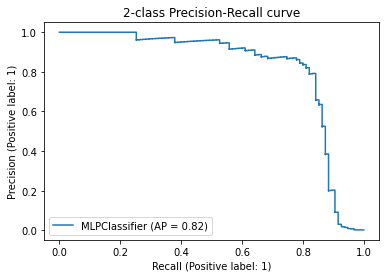

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

trainPredetto = best_model.predict(X_train)
testPredetto = best_model.predict(X_test)

cm = confusion_matrix(Y_test, testPredetto, labels=[0, 1])

cmatrix = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non Frode","Frode"])
cmatrix.plot()
plt.title("Matrice di Confusione")
plt.show()

from sklearn.metrics import accuracy_score

veriNegativi = cm[0][0]
veriPositivi = cm[1][1]
falsiPositivi = cm[0][1]
falsiNegativi = cm[1][0]   

nonFrodiTotali = veriNegativi + falsiPositivi
frodiTotali = veriPositivi + falsiNegativi

percentualeDiSuccessoNonFrodi = veriNegativi / nonFrodiTotali
percentualeDiSuccessoFrodi = veriPositivi / frodiTotali

precision = veriPositivi/(veriPositivi + falsiPositivi)
recall = veriPositivi/(veriPositivi + falsiNegativi)
print("Train score     : {:.2f} %".format(accuracy_score(trainPredetto, Y_train) * 100))
print("Test Accuracy     : {:.2f} %".format(accuracy_score(testPredetto, Y_test) * 100))
print("Test Precision     : {:.2f} %".format(100 * precision))
print("Test Recall     : {:.2f} %".format(100 * recall))
print("Test F1     : {:.2f} %".format(100 * 2 * precision * recall /(precision + recall)))

print("Accuratezza riconoscimento frodi : {:.2f} %".format(percentualeDiSuccessoFrodi*100))
print("Accuratezza riconoscimento non frodi : {:.2f} %".format(percentualeDiSuccessoNonFrodi*100))

from sklearn.metrics import average_precision_score

baseline = frodiTotali/(frodiTotali + nonFrodiTotali)
auprc = average_precision_score(Y_test, testPredetto)

print(baseline, auprc, sep="\t")

from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(best_model, X_test, Y_test)

_ = display.ax_.set_title("2-class Precision-Recall curve")

In [16]:
print(best_model.hidden_layer_sizes)
print(best_model.activation)

(100, 20)
relu


In [39]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neural_network import MLPClassifier
gridParams = {
    'activation': ["tanh", "relu"],
    'solver': ["lbfgs", "adam"],
    'hidden_layer_sizes': [(150, 3), (150, 5)]
}
rfCLF = MLPClassifier(max_iter=300)
#stratified = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1234)
gridSearch = GridSearchCV(estimator = rfCLF,
                          param_grid = gridParams,
                          scoring = 'f1',
                          #cv = stratified,
                          n_jobs = -1)
gridSearch.fit(X_train, Y_train)

/Applications/anaconda3/envs/mongoDB/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda3/envs/mongoDB/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda3/envs/mongoDB/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Applications/anaconda3/envs/mongoDB/lib/python3.8/site-packages/sklearn/